In [39]:
import warnings
warnings.filterwarnings('ignore')

## Regular expressions
Regular expressions are text extraction tools that allow you to match text patterns based on a standardized rulesets. This allows for fast parsing of text. It's super smart.

To find a four digit number use \d to look for digits and {4} to find exactly 4 occurrences.

In [40]:
import re

pat = r'\d{4}'
text = """superTousled try-hard blog Carles, typewriter fap hella salvia fanny pack selvage mlkshk crucifix. 
Next level retro quinoa post-ironic. Heirloom keffiyeh synth street art meggings, drinking vinegar Schlitz actually raw denim. 
1234 Normcore freegan post-ironic meggings cred, cardigan yr locavore 3 wolf moon. Bitters ennui ugh superpolaroid, 
artisan scenester distillery kale chips wolf pork belly keffiyeh. Actually Tumblr twee [[drinking vinegar]], 
squid pickled cronut banh mi taxidermy deep v 8-bit narwhal Odd Future. Sriracha bicycle rights listicle, keffiyeh typewriter 
authentic selvage cred selfies. Ugh lo-fi tattooed chambray, DIY Marfa banh mi whatever narwhal jean shorts photo booth keytar 
listicle. Chambray Truffaut cardigan skateboard, hashtag disrupt next level. Normcore Blue Bottle yr, Odd Future skateboard 
chillwave iPhone slow-carb sriracha letterpress meditation cronut. IPhone fashion axe Neutra fingerstache tofu gluten-free 
[[gentrify]], wolf before they sold out pork belly retro Vice skateboard DIY Marfa. Mustache supertaxidermy cliche 9999 fashion 
axe Pitchfork, iPhone cred literally McSweeney's normcore. Health goth meggings skateboard 90's 3 wolf moon, PBR&B kale chips 
biodiesel fashion axe. Sartorial crucifix retro, four dollar toast kogi forage swag deep v wayfarers tilde. Synth typewriter 
messenger bag health goth scenester pour-over. Pour-over Truffaut 90s fashion axe post-ironic, Portland Wes Anderson forage 
occupy sartorial gentrify hashtag beard kitsch quinoa. Occupy [[hashtag]] street art 3 wolf moon, Echo Park quinoa Tumblr 
Pitchfork fanny pack High Life. Helvetica banjo gentrify authentic mumblecore, tote bag blog. Scenester +1 American Apparel 
organic literally, Intelligentsia butcher bitters. Seitan lumbersexual fanny pack organic, letterpress umami ethical wayfarers. 
Cronut biodiesel Wes Anderson, jean shorts lo-fi keffiyeh Carles. Bushwick health goth chambray gluten-free distillery. 
Keytar selvage Shoreditch, seitan YOLO tote bag listicle Marfa farm-to-table keffiyeh meditation tilde. Narwhal freegan 
meditation, Pitchfork XOXO Brooklyn 23456 whatever photo booth pork belly Blue Bottle gluten-free. Semiotics fashion axe 3 
wolf moon, selfies brunch skateboard shabby chic organic wayfarers yr whatever kitsch Thundercats tilde bespoke. 
[[Bicycle|Bicycle(two-wheeled type)]] rights seitan mlkshk Marfa, church-key cray mustache sartorial banh mi food truck 
chillwave Echo Park bitters. Craft superbeer bespoke street art, slow-carb pop-up Kickstarter typewriter Etsy try-hard 
[[Pitchfork|Pitchfork Magazine]] aesthetic keytar Tumblr. 8-bit bitters fanny pack, Portland Odd Future yr selvage crucifix 
narwhal polaroid sriracha Thundercats."""
match = re.search(pat, text)
if match:
    print match.group()

1234


Let's make a regex for finding any word that begins with super, i.e. any word with preceding whitespace or beginning of the line.

In [41]:
pat = r'(^|\s)(super\w+)'
matches = re.findall(pat, text)
for match in matches:
    print match[1]

superTousled
superpolaroid
supertaxidermy
superbeer


Next step is finding links formatted as [[link]] or [[link|alternative_link]]

In [42]:
pat = r'\[\[([^\|\]]+)\|?([\w\s\D]*?)\]\]'
matches = re.findall(pat, text)
for match in matches:
    print match

('drinking vinegar', '')
('gentrify', '')
('hashtag', '')
('Bicycle', 'Bicycle(two-wheeled type)')
('Pitchfork', 'Pitchfork Magazine')


## Finding philosophers from Wikipedia
We will find philosophers based on the page, "list of philosophers" and analyze their relation to one another

In [6]:
# Bunch of helper functions

from __future__ import print_function
import pickle
import re
import json
import matplotlib.pyplot as plt
import networkx as nx
from collections import *
import sys
import io
from os import listdir
from os.path import isfile, join
import urllib2 as url

def safeprint(s):
    try:
        print(s)
    except UnicodeEncodeError:
        if sys.version_info >= (3,):
            print(s.encode('utf8').decode(sys.stdout.encoding))
        else:
            print(s.encode('utf8'))

def unpicklePhil(name):
    path = 'phils/' + name
    with io.open(path, 'rb') as file:
        d = pickle.load(file)
    picklePhil(name, d)
    return d

def picklePhil(name, data):
    path = 'phils/' + name
    with io.open(path, 'wb') as file:
        pickle.dump(data, file, protocol=2)

def getContent(philObject):
	try: 
		return philObject['query']['pages'].itervalues().next()['revisions'][0]['*']
	except KeyError:
		return None

def findWikiLinks(string):
    pat = r'\[\[([^\|\]]+)\|?([\w\s\D]*?)\]\]'
    matches = re.findall(pat, string)
    return matches

def plotLogDegree(graph):
    d_in = Counter(G.in_degree())
    y_in = Counter(d_in.values()).values()
    x_in = sorted(set(d_in.values()))
    d_out = Counter(G.out_degree())
    y_out = Counter(d_out.values()).values()
    x_out = sorted(set(d_out.values()))
    plt.loglog(x_in,y_in, 'ro-') # Plot the in degree distribution
    plt.loglog(x_out, y_out, 'bv-') # Plot the out degree distribution
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.legend(['In degree', 'Out degree'])
    plt.legend()
    plt.show()

Downloading these philosophers takes forever, so let's make sure we only download them once. It still seems like it's downloading some every time, so take a look at that function again when there's time.

In [4]:
# First get the lists of different philophers
branches = ["List_of_aestheticians","List_of_epistemologists","List_of_ethicists","List_of_logicians","List_of_metaphysicians","List_of_social_and_political_philosophers"]
endpoint = 'https://en.wikipedia.org/w/api.php'
action = 'query'
pllimit = 500
prop = 'links'
branchData = []

# Download the list of philosophers if we did not already save them
if not isfile('phillist.txt'):
    for branch in branches:
        title = branch
        data = "action={}&titles={}&prop={}&pllimit={}&format=json&continue=".format(action,title,prop, pllimit)
        u = url.urlopen(endpoint, data)
        data = json.loads(u.readlines()[0])
        branchData.append(data)
    with io.open('phillist.txt', 'wb') as file:
        pickle.dump(branchData, file, protocol=2)
else:
    with io.open('phillist.txt', 'rb') as file:
        branchData = pickle.load(file)

# Remove any titles that have words with non-capital letters that are not 'of', 'von' or 'de' and store the philo
# -sophers in a list of tuples instead
p = []
regFilter = r'(?!^of$)(?!^von$)(?!^de$)^[a-z]+|Wiki|[\:\\\/]'
for i in range(0, len(branchData)):
    key = branchData[i]['query']['pages'].itervalues().next()['title']
    p.append((key, []))
    links = branchData[i]['query']['pages'].itervalues().next()['links']
    for link in links:
        matches = [re.search(regFilter, word) for word in link['title'].split(" ")]
        if not any(matches):
            p[i][1].append(link['title'])

# Find number of branchData in different branches
for branch in p:
    safeprint("Length of {}:{}".format(branch[0].lower(), len(branch[1])))

philSet = set()
for i in range(0, len(p)):
    s = set(p[i][1])
    philSet = philSet.union(s)

# Find the ones we've already downloaded
onlyfiles = [ f for f in listdir('./phils') if isfile(join('./phils',f)) ]
# Fetch each philosopher
uniquePhils = list(philSet.difference(set(onlyfiles)))
prop = 'revisions'
rvprop = 'content'
for i in range(0, len(uniquePhils)):
    title = url.quote(uniquePhils[i].encode('utf-8'))
    safeprint("Fetching" + title)
    data = "action={}&titles={}&prop={}&rvprop={}&format=json&continue=".format(action,title,prop, rvprop)
    u = url.urlopen(endpoint, data)
    wikiData = json.loads(u.readlines()[0])
    picklePhil(uniquePhils[i], wikiData)

Length of list of aestheticians:129
Length of list of epistemologists:133
Length of list of ethicists:303
Length of list of logicians:289
Length of list of metaphysicians:178
Length of list of social and political philosophers:368
FetchingAndrea%20Bonom%C3%AC
FetchingClaude%20Adrien%20Helv%C3%A9tius
FetchingAnt%C3%B3nio%20Castanheira%20Neves
FetchingJean-Fran%C3%A7ois%20Lyotard
FetchingStanis%C5%82aw%20Le%C5%9Bniewski
FetchingSlavoj%20%C5%BDi%C5%BEek
FetchingJan%20%C5%81ukasiewicz
FetchingMartin%20Luther%20King%2C%20Jr.
FetchingGy%C3%B6rgy%20Luk%C3%A1cs
FetchingNiccol%C3%B2%20Machiavelli
FetchingYamaga%20Sok%C5%8D
FetchingHans%20K%C3%B6chler
Fetching%C4%B0oanna%20Ku%C3%A7uradi
FetchingHorace%20Romano%20Harr%C3%A9
Fetching%C3%89tienne%20de%20La%20Bo%C3%A9tie
FetchingClaude%20L%C3%A9vi-Strauss
FetchingPer%20Martin-L%C3%B6f
FetchingLaurence%20BonJour
FetchingTadeusz%20Kotarbi%C5%84ski
FetchingRoland%20Fra%C3%AFss%C3%A9
Fetching%C3%89mile%20Durkheim
FetchingOliver%20Wendell%20Holmes%2C%20J

C:\Python27\Lib\site-packages\ipykernel\__main__.py:48: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Now we construct the network of philosophers. This takes some time as well, so maybe consider pickling the graph.

In [ ]:
# Load in all the philosophers
phils = [ f for f in listdir('./phils') if isfile(join('./phils',f)) ]

G = nx.DiGraph()

# Create a node for each philosopher
[G.add_node(phil) for phil in phils]

for phil in phils:
	philObject = unpicklePhil(phil)
	philContent = getContent(philObject)
	if philContent:
		links = findWikiLinks(philContent)
		for link in links:
			if link[0] in phils:
				G.add_edge(phil, link[0])


Find the network hubs.

In [10]:
# Find the top 10 linked to philosophers
d_in = Counter(G.in_degree())
d_out = Counter(G.out_degree())
print(d_in.most_common(10))
print(d_out.most_common(10))

[('Immanuel Kant', 180), ('Aristotle', 176), ('Plato', 142), ('Bertrand Russell', 119), ('Karl Marx', 110), ('David Hume', 93), ('Philosophy', 90), ('Friedrich Nietzsche', 87), ('John Locke', 85), ('Metaphysics', 84)]
[('Philosophy', 108), ('Metaphysics', 60), ('Georg Wilhelm Friedrich Hegel', 55), ('Ontology', 54), ('Libertarianism', 49), ('Immanuel Kant', 49), ('Bertrand Russell', 48), ('David Hume', 47), ('Truth', 47), ('Friedrich Nietzsche', 46)]


It seems as though particularly the out distribution will be polluted by philosophical concepts still being in the mix. Maybe remove them using the category keywords.

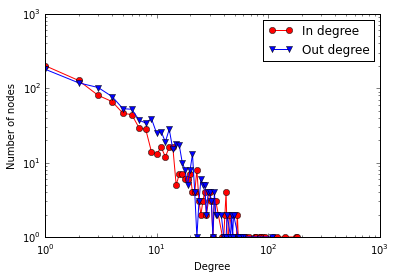

In [9]:
%matplotlib inline
plotLogDegree(G)

The above looks like it's a scale free network due to the log linear nature which indicates a large number of hubs. Since the philosophers can be seen as a social network I would also expect this, but it does seem as though the distribution tapers off a bit faster than normal. For some reason I was also expecting there to be bigger difference on the in and out distributions, but this is not apparent. 